In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

gray_level = 256  # 图像灰度值从0到255，白色为255，黑色为0

In [76]:
def probability(img):
    """
    计算像素值出现概率
    """
    assert isinstance(img, np.ndarray)

    prob = np.zeros(shape=(256))

    for row in img:
        for num in row:
            prob[num] += 1

    row, column = img.shape
    prob = prob / (row * column)

    return prob

def plot(y, name):
    """
    画直方图，len(y)==gray_level
    """
    plt.figure(num=name)
    plt.bar([i for i in range(gray_level)], y, width=1)


In [4]:
# def main():
#     # 读取灰度图
#     img = cv2.imread("1.jpg", 0) #图1

#     # 计算归一化后的灰度概率并绘制直方图
#     prob = probability(img)
#     plot(prob, "原图灰度直方图") #图2

#     # 直方图均衡化
#     img = probability_to_histogram(img, prob)
#     cv2.imwrite(r"after_balance.jpg", img) #图3
#     prob = probability(img)
#     plot(prob, "直方图均衡化结果") #图4

#     # 直方图规定化
#     img = cv2.imread("after_balance.jpg", 0)
#     scr = cv2.imread("target.jpg", 0)  #图5
#     plot(probability(scr), "目标图灰度直方图")  #图6
#     result = histogram_specification(img,scr)
#     cv2.imshow("规定化后的图像", result)
#     cv2.imwrite(r"after_specification.jpg", img) #图7
#     cv2.waitKey(0)
#     plt.hist(result.ravel(), 256) #图8
#     plt.show()


#     # 局部直方图处理
#     img = cv2.imread('./local.jpg',0)  #图9
#     histogram_local(img) # 图10

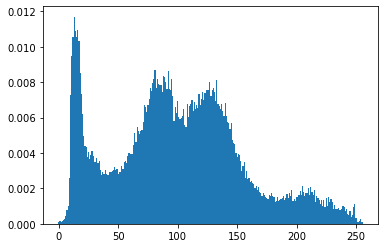

In [13]:
img = cv2.imread('imgs/1.2.jpg',0) 
prob = probability(img)
plot(prob, "原图灰度直方图")

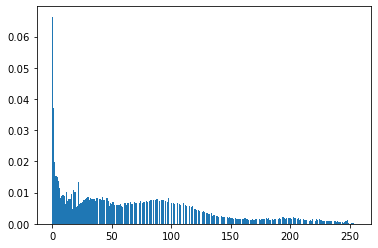

In [14]:
def probability_to_histogram(img, prob):
    """
    根据像素概率将原始图像直方图均衡化
    :return: 直方图均衡化后的图像
    """
    prob = np.cumsum(prob)  # 累计概率

    img_map = [int(i * prob[i]) for i in range(256)]  # 像素值映射

   # 像素值替换
    assert isinstance(img, np.ndarray)
    r, c = img.shape
    for ri in range(r):
        for ci in range(c):
            img[ri, ci] = img_map[img[ri, ci]]

    return img

img_balance = probability_to_histogram(img, prob)
cv2.imwrite(r"imgs/after_balance.jpg", img_balance)
prob = probability(img_balance)
plot(prob, "原图灰度直方图")

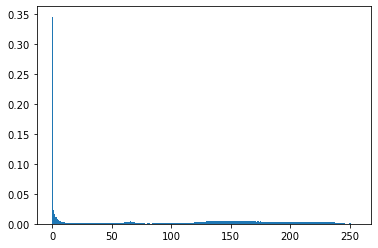

In [50]:
img = cv2.imread("imgs/1.2.jpg", 0)
scr = cv2.imread("imgs/1.1.jpg", 0)  #图5
plot(probability(scr), "目标图灰度直方图")  #图6

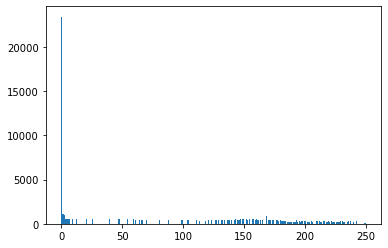

In [51]:
def histogram_specification(img,scr):
    '''
    进行直方图的规定化
    '''
    mHist1 = []
    mNum1 = []
    inhist1 = []
    mHist2 = []
    mNum2 = []
    inhist2 = []
    # 对原图像进行均衡化
    for i in range(256):
        mHist1.append(0)
    row, col = img.shape  # 获取原图像像素点的宽度和高度
    for i in range(row):
        for j in range(col):
            mHist1[img[i, j]] = mHist1[img[i, j]] + 1  # 统计灰度值的个数
    mNum1.append(mHist1[0] / img.size)
    for i in range(0, 255):
        mNum1.append(mNum1[i] + mHist1[i + 1] / img.size)
    for i in range(256):
        inhist1.append(round(255 * mNum1[i]))
    # 对目标图像进行均衡化
    for i in range(256):
        mHist2.append(0)
    rows, cols = scr.shape  # 获取目标图像像素点的宽度和高度
    for i in range(rows):
        for j in range(cols):
            mHist2[scr[i, j]] = mHist2[scr[i, j]] + 1  # 统计灰度值的个数
    mNum2.append(mHist2[0] / scr.size)
    for i in range(0, 255):
        mNum2.append(mNum2[i] + mHist2[i + 1] / scr.size)
    for i in range(256):
        inhist2.append(round(255 * mNum2[i]))
    g = []  # 用于放入规定化后的图片像素
    for i in range(256):
        a = inhist1[i]
        flag = True
        for j in range(256):
            if inhist2[j] == a:
                g.append(j)
                flag = False
                break
        if flag == True:
            minp = 255
            for j in range(256):
                b = abs(inhist2[j] - a)
                if b < minp:
                    minp = b
                    jmin = j
            g.append(jmin)
    row,col = img.shape
    for i in range(row):
        for j in range(col):
            img[i, j] = g[img[i, j]]
    return img

result = histogram_specification(img,scr)
cv2.imshow("规定化后的图像", result)
cv2.imwrite(r"after_specification.jpg", img) #图7
cv2.waitKey(0)
plt.hist(result.ravel(), 256) #图8
plt.show()

In [77]:
def histogram_local(img):
    global hisImg,localHistImg
    H = img.shape[0]
    W = img.shape[1]

    hr = np.zeros(256)  # 原始直方图信息
    pr = np.zeros(256)  # 原始图片的概率
    rtos = np.zeros(256)  # r->s的映射

    # 计算原始图片的像素分布图和概率密度函数
    for row in range(H):
        for col in range(W):
            hr[img[row, col]] += 1

    for i in range(256):
        pr[i] = hr[i] / (H * W)

    for i in range(256):  # i=[0,255]
        for j in range(i + 1):  # j=[0,i]
            rtos[i] += pr[j]
        rtos[i] = round(rtos[i] * 255)  # 四舍五入取整

    hisImg = np.zeros((H, W, 3), np.uint8)  # 建立直方图均衡变换之后的图片
    for row in range(H):
        for col in range(W):
            hisImg[row, col] = rtos[img[row, col]]

    # 局部直方图变换，使用3*3的邻域统计直方图
    localsize = 3  # 邻域的尺寸为3*3，这个邻域值最好为奇数
    tempImg = np.zeros((H + localsize - 1, W + localsize - 1, 3), np.uint8)  # 创建一个边界大一半领域像素的值，以便统计边缘像素
    localHistImg = np.zeros((H, W, 3), np.uint8)  # 存储新图
    for row in range(H):
        for col in range(W):
            tempImg[row + (localsize - 1) // 2, col + (localsize - 1) // 2] = img[row, col]
    for row in range((localsize - 1) // 2, H + (localsize - 1) // 2):
        for col in range((localsize - 1) // 2, W + (localsize - 1) // 2):  # 外层大循环
            # 每行统计新加入的点和删除的点是否具有相同的灰度值，这里localsize是3，所以用row,row-1,row+1三行
            # 只要比较0通道的值就行，对于灰度图来说，三个通道的值相同
            if row <= (localsize - 1) // 2 or col <= (localsize - 1) // 2 \
                    or row > H - 1 or col > W - 1 \
                    or tempImg[row, col - 2, 0] != tempImg[row, col + 2, 0] \
                    or tempImg[row - 1, col - 2, 0] != tempImg[row - 1, col + 2, 0] \
                    or tempImg[row + 1, col - 2, 0] != tempImg[row + 1, col + 2, 0]:
                # 每一行一列重新计算概率分布
                for i in range(256):
                    pr[i] = 0
                    rtos[i] = 0
                for i in range(localsize):
                    for j in range(localsize):
                        pr[tempImg[row + (i - (localsize - 1) // 2), col + (j - (localsize - 1) // 2)]] += 1
                for i in range(256):
                    for j in range(i + 1):
                        rtos[i] += pr[j]
                    rtos[i] = round(rtos[i] * 255 / (localsize * localsize))
            localHistImg[row - (localsize - 1) // 2, col - (localsize - 1) // 2] = rtos[tempImg[row, col]]
            
img = cv2.imread('imgs/1.5.jpg',0)  #图9
histogram_local(img) # 图10

In [79]:
cv2.imwrite("imgs/after_his.jpg",hisImg)
cv2.imwrite("imgs/after_local.jpg",localHistImg)

True

In [72]:
cv2.destroyAllWindows()